In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNBthe
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [137]:
# read season game data and print out liklihood of home winning 
games_data = pd.read_csv('GameData/2016_all_games.csv', parse_dates=['Date'])
games_data['Home_Wins'] = games_data['HPTS']>games_data['VPTS']
games_data['Home_Wins'].mean()
# Winning team more likely to win

0.5942249240121581

In [138]:
games_data

,Date,Start (ET),Visitor,VPTS,Home,HPTS,Box Score,OT?,Attend.,Notes,Home_Wins
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN,True
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN,False
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN,True
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN,False
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
1311,2016-06-08,9:00p,Golden State Warriors,90,Cleveland Cavaliers,120,Box Score,NaN,20562,NaN,True
1312,2016-06-10,9:00p,Golden State Warriors,108,Cleveland Cavaliers,97,Box Score,NaN,20562,NaN,False
1313,2016-06-13,9:00p,Cleveland Cavaliers,112,Golden State Warriors,97,Box Score,NaN,19596,NaN,False
1314,2016-06-16,9:00p,Golden State Warriors,101,Cleveland Cavaliers,115,Box Score,NaN,20562,NaN,True


# Get Feature to Predict Home_Wins

In [139]:
# Determine if the teams won the previous game they played going into the match
def won_prev_game(df):
    won_prev = defaultdict(int)
    
    for index, row in df.iterrows():
        home = row["Home"]
        visitor = row["Visitor"]
        # update the df
        df.at[index,"Home_Won_Prev"] = won_prev[home]
        df.at[index,"Visitor_Won_Prev"] = won_prev[visitor]
        # update the default dict
        won_prev[home] = int(row["Home_Wins"])
        won_prev[visitor] = 1 - int(row["Home_Wins"])
    
    return df

In [140]:
games_data = won_prev_game(games_data)

In [141]:
# Calculate the win streak both teams are on going into the match
def win_streak_number(df):
    win_streak = defaultdict(int)
    
    for index, row in df.iterrows():
        home = row["Home"]
        visitor = row["Visitor"]
        # update the df
        df.at[index,"Home_Win_Streak"] = win_streak[home]
        df.at[index,"Visitor_Win_Streak"] = win_streak[visitor]
        # update the default dict
        if row["Home_Wins"]:
            win_streak[home] = win_streak[home] + 1
            win_streak[visitor] = 0
        else:
            win_streak[home] = 0
            win_streak[visitor] = win_streak[visitor] + 1
    
    return df

In [142]:
games_data = win_streak_number(games_data)

In [143]:
# Get Wins and Loss Up To Current Point for both teams
def win_loss_current(df):
    wins = defaultdict(int)
    #start losses off at 1 for easier math
    losses = defaultdict(lambda:1)
    
    for index, row in df.iterrows():
        home = row["Home"]
        visitor = row["Visitor"]
        # update the df
        df.at[index,"Home_Total_Wins"] = wins[home]
        df.at[index,"Visitor_Total_Wins"] = wins[visitor]
        df.at[index,"Home_Total_Losses"] = losses[home]
        df.at[index,"Visitor_Total_Losses"] = losses[visitor]
        # update the default dict
        if row["Home_Wins"]:
            wins[home] = wins[home] + 1
            losses[visitor] = losses[visitor] + 1
        else:
            wins[visitor] = wins[visitor] + 1
            losses[home] = losses[home] + 1
    
    return df

In [144]:
games_data = win_loss_current(games_data)

In [145]:
# determine if home has a current higher win percentage than visitor
games_data['Home_Win%'] = games_data['Home_Total_Wins'] / (games_data['Home_Total_Wins'] + games_data['Home_Total_Losses'])
games_data['Visitor_Win%'] = games_data['Visitor_Total_Wins'] / (games_data['Visitor_Total_Wins'] + games_data['Visitor_Total_Losses'])
games_data['HomeRanksHigherCurrent'] = games_data['Home_Win%'] >= games_data['Visitor_Win%']


In [146]:
def won_last_matchup(df):
    last_winner = defaultdict(lambda:'Hello')
    
    for index, row in df.iterrows():
        home = row["Home"]
        visitor = row["Visitor"]
        match_teams = tuple(sorted([home,visitor]))
        res = last_winner[match_teams]
        # update the df      
        df.at[index,"Home_Won_Last_Match"] = True if res==row["Home"] else False
        # update the default dict
        if row["Home_Wins"]:
            last_winner[match_teams] = row["Home"]
        else:
            last_winner[match_teams] = row["Visitor"]
    return df

In [147]:
games_data = won_last_matchup(games_data)
games_data

,Date,Start (ET),Visitor,VPTS,Home,HPTS,Box Score,OT?,Attend.,Notes,...,Home_Win_Streak,Visitor_Win_Streak,Home_Total_Wins,Visitor_Total_Wins,Home_Total_Losses,Visitor_Total_Losses,Home_Win%,Visitor_Win%,HomeRanksHigherCurrent,Home_Won_Last_Match
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,2016-06-08,9:00p,Golden State Warriors,90,Cleveland Cavaliers,120,Box Score,NaN,20562,NaN,...,0.0,5.0,69.0,87.0,30.0,15.0,0.696970,0.852941,False,False
1312,2016-06-10,9:00p,Golden State Warriors,108,Cleveland Cavaliers,97,Box Score,NaN,20562,NaN,...,1.0,0.0,70.0,87.0,30.0,16.0,0.700000,0.844660,False,True
1313,2016-06-13,9:00p,Cleveland Cavaliers,112,Golden State Warriors,97,Box Score,NaN,19596,NaN,...,1.0,0.0,88.0,70.0,16.0,31.0,0.846154,0.693069,True,True
1314,2016-06-16,9:00p,Golden State Warriors,101,Cleveland Cavaliers,115,Box Score,NaN,20562,NaN,...,1.0,0.0,71.0,88.0,31.0,17.0,0.696078,0.838095,False,True


# Predict Winner From Generated Columns

In [148]:
# x = np.array(games_data[['Home_Won_Prev', 
#                          'Visitor_Won_Prev', 
#                          'Home_Win_Streak', 
#                          'Visitor_Win_Streak',
#                          'HomeRanksHigherCurrent',
#                          'Home_Won_Last_Match']])

# got better results including more of the features
X = np.array(games_data[['Home_Won_Prev', 
                         'Visitor_Won_Prev', 
                         'Home_Win_Streak', 
                         'Visitor_Win_Streak',
                         'HomeRanksHigherCurrent',
                         'Home_Won_Last_Match',
                         'Home_Win%',
                         'Visitor_Win%',
                         'Home_Total_Wins',
                         'Home_Total_Losses',
                         'Visitor_Total_Wins',
                         'Visitor_Total_Losses'
                        ]])
y = np.array(games_data['Home_Wins'])

Text(0, 0.5, 'Cross-Validated Accuracy')

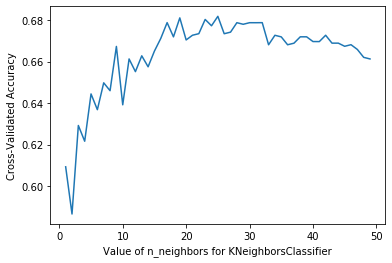

In [149]:
# find the best paramters for the different model and plot them
k_range = range(1,50)
k_scores = []
for k in k_range:
    svc = make_pipeline(
        StandardScaler(),
#         SVC(kernel='linear', C=k) #0.657 @ C=10 
#         GaussianNB()
#         LogisticRegression(C=k) #0.67 @ C=3
        KNeighborsClassifier(n_neighbors=k)
#         RandomForestClassifier(n_estimators=k)
    )
    scores = cross_val_score(svc,X,y,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of n_neighbors for KNeighborsClassifier')
plt.ylabel('Cross-Validated Accuracy')

In [172]:
# use the model and paramter that yield the highest accuracy for cross-validation and print the score
model = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=25)
    )
scores = cross_val_score(model,X,y,cv=10,scoring='accuracy')
print("KNeighborsClassifier Model - Cross Validation Prediction Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

KNeighborsClassifier Model - Cross Validation Prediction Accuracy: 68.2%


In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=25, p=2,
                                      weights='uniform'))],
         verbose=False)

# Use This Model To Predict Future Season (2018/2019 NBA Season)

In [168]:
curr_games = pd.read_csv('GameData/2019_all_games.csv', parse_dates=['Date'])
curr_games['Home_Wins'] = curr_games['HPTS']>curr_games['VPTS']
curr_games['Home_Wins'].mean()
# same base line found for 2019 season. Interesting

0.5907012195121951

In [169]:
curr_games = won_prev_game(curr_games)
curr_games = win_streak_number(curr_games)
curr_games = win_loss_current(curr_games)
curr_games = win_loss_current(curr_games)

# determine if home has a current higher win percentage than visitor
curr_games['Home_Win%'] = curr_games['Home_Total_Wins'] / (curr_games['Home_Total_Wins'] + curr_games['Home_Total_Losses'])
curr_games['Visitor_Win%'] = curr_games['Visitor_Total_Wins'] / (curr_games['Visitor_Total_Wins'] + curr_games['Visitor_Total_Losses'])
curr_games['HomeRanksHigherCurrent'] = curr_games['Home_Win%'] >= curr_games['Visitor_Win%']

curr_games = won_last_matchup(curr_games)
curr_games

,Date,Start (ET),Visitor,VPTS,Home,HPTS,Box Score,OT?,Attend.,Notes,...,Home_Win_Streak,Visitor_Win_Streak,Home_Total_Wins,Visitor_Total_Wins,Home_Total_Losses,Visitor_Total_Losses,Home_Win%,Visitor_Win%,HomeRanksHigherCurrent,Home_Won_Last_Match
0,2018-10-16,8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,18624,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
1,2018-10-16,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
2,2018-10-17,7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,17889,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
3,2018-10-17,7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,20332,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
4,2018-10-17,7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,17923,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,2019-06-02,8:00p,Golden State Warriors,109,Toronto Raptors,104,Box Score,NaN,20014,NaN,...,5.0,0.0,71.0,69.0,31.0,31.0,0.696078,0.690000,True,True
1308,2019-06-05,9:00p,Toronto Raptors,123,Golden State Warriors,109,Box Score,NaN,19596,NaN,...,1.0,0.0,70.0,71.0,31.0,32.0,0.693069,0.689320,True,True
1309,2019-06-07,9:00p,Toronto Raptors,105,Golden State Warriors,92,Box Score,NaN,19596,NaN,...,0.0,1.0,70.0,72.0,32.0,32.0,0.686275,0.692308,False,False
1310,2019-06-10,9:00p,Golden State Warriors,106,Toronto Raptors,105,Box Score,NaN,20144,NaN,...,2.0,0.0,73.0,70.0,32.0,33.0,0.695238,0.679612,True,True


In [170]:
X_predict = np.array(curr_games[['Home_Won_Prev', 
                         'Visitor_Won_Prev', 
                         'Home_Win_Streak', 
                         'Visitor_Win_Streak',
                         'HomeRanksHigherCurrent',
                         'Home_Won_Last_Match',
                         'Home_Win%',
                         'Visitor_Win%',
                         'Home_Total_Wins',
                         'Home_Total_Losses',
                         'Visitor_Total_Wins',
                         'Visitor_Total_Losses'
                        ]])

y_to_predict = np.array(curr_games['Home_Wins'])

In [171]:
y_predicted = model.predict(X_predict)
accuracy = np.mean(y_to_predict == y_predicted) * 100
print("Model Accuracy Predicting 2019 NBA Season Data: {0:.1f}%".format(accuracy))

Model Accuracy Predicting 2019 NBA Season Data: 63.2%
